<a href="https://colab.research.google.com/github/yonghyeokrhee/personalize/blob/master/homeshopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function

import boto3
from decimal import Decimal
import json
import urllib
import io
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
%matplotlib inline
from botocore.exceptions import ClientError

In [ ]:
import json
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt 
%matplotlib inline
import os
os.getcwd()

'C:\\Users\\user\\Documents'

In [ ]:
pd.options.display.max_rows = 999

In [ ]:
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
personalize = boto3.client(service_name='personalize', endpoint_url='https://personalize.us-west-2.amazonaws.com', region_name='us-west-2')
personalize_runtime = boto3.client(service_name='personalize-runtime', endpoint_url='https://personalize-runtime.us-west-2.amazonaws.com', region_name='us-west-2')

In [ ]:
files = ['20190613_1.csv','20190613_2.csv','20190613_3.csv',
         '20190613_4.csv','20190613_5.csv']

In [ ]:
df = pd.DataFrame()
for i in files:
    temp = pd.read_csv(i)
    df = pd.concat([df,temp])

In [ ]:
df.to_csv("raw_data_full.csv")

In [ ]:
s3 = boto3.Session().resource('s3')
my_bucket = s3.Bucket('personalize-dsc')

for my_bucket_object in my_bucket.objects.all():
    print(my_bucket_object)

s3.ObjectSummary(bucket_name='personalize-dsc', key='DEMO-movie-lens-100k.csv')
s3.ObjectSummary(bucket_name='personalize-dsc', key='cartorzzim.csv')
s3.ObjectSummary(bucket_name='personalize-dsc', key='raw_data.csv')


In [ ]:
df = pd.read_csv('C:/Users/user/Downloads/raw_data.csv', index_col=0)

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
words = ['특가', '파격', 'SALE', '1+1', '할인', '초특가']
title = '|'.join(words)


In [ ]:
zzim = pd.read_csv('cartorzzim.csv')

In [ ]:
zzim.head()

,TIMESTAMP,USER_ID,EVENT_TYPE,ITEM_ID,LGROUP_NAME,MGROUP_NAME,SGROUP_NAME,DGROUP_NAME,BRAND_NAME,BRAND_CODE,ITEM_NAME,ITEM_CODE,MD_NAME,MD_CODE
0,2019/01/01 00:00,201701443671,cart,10049381,패션,여성의류,아우터,코트,요하넥스,1648,요하넥스_코트,54376,의류,11
1,2019/01/01 00:00,201701503299,zzim,10061085,리빙,건강/헬스,건강매트,안마매트,메디칼드림,144,메디칼드림_안마매트,1160,리빙,31
2,2019/01/01 00:01,201602306115,cart,10060946,패션,여성의류,하의,데님,비지트인뉴욕,1634,비지트인뉴욕_데님,101643,의류,11
3,2019/01/01 00:01,201602309528,cart,10058998,패션,언더웨어,여성속옷,양말/스타킹/레깅스,비비안,2483,비비안_양말/스타킹/레깅스,101424,온라인,61
4,2019/01/01 00:01,201811491154,cart,10053689,주방,주방가전,조리기,튀김기,일렉트로맨,1852,일렉트로맨_튀김기,82550,주방,21


In [ ]:
zzim.rename(columns={'YYYYMMDDHHMI':'TIMESTAMP','CUST_NO':'USER_ID','GOODS_CODE':'ITEM_ID'}, inplace=True)

In [ ]:
zzim.rename(columns={'C_OR_Z':'EVENT_TYPE'}, inplace=True)

In [ ]:
df_times = df[['FIRST_ORDER_DATE','LAST_ORDER_DATE','ORDER_DATE']]

In [ ]:
df[['GOODS_NAME','SALE_PRICE','RSALE_AMT','CHANGE_RATE_AMT']].head()

,GOODS_NAME,SALE_PRICE,RSALE_AMT,CHANGE_RATE_AMT
0,[반값딜] 카밀 핸드크림 클래식 1+1,8500,4250,3953
1,(홀리데이 구성) 엘렌실라 달팽이크림 50g*5개 + EGF크림 50g*5개 + 파...,79000,78000,63960
2,김나운 손질새우 140g(20미)/팩 x 13팩 (총 260미),60900,59900,50915
3,백년의삶 동안석류즙 70ml*105포 (N035),79900,78900,63909
4,(고객감사특가) 럭키샵 마르조 리버시블 항공점퍼 1+1,39800,38800,22504


In [ ]:
df[['SALE_PRICE','DC_ARS', 'DC_NOREST', 'DC_GOODS', 'DC_COUPON', 'DC_AMT_PARTNER',
       'RSALE_AMT', 'CHANGE_RATE_AMT']].head()

,SALE_PRICE,DC_ARS,DC_NOREST,DC_GOODS,DC_COUPON,DC_AMT_PARTNER,RSALE_AMT,CHANGE_RATE_AMT
0,8500,0,0,4250,0,0,4250,3953
1,79000,1000,0,0,0,0,78000,63960
2,60900,1000,0,0,0,0,59900,50915
3,79900,1000,0,0,0,0,78900,63909
4,39800,1000,0,0,0,0,38800,22504


In [ ]:
batch = df[['GOODS_CODE','GOODS_NAME','LGROUP_NAME', 'MGROUP_NAME',
       'SGROUP_NAME', 'DGROUP_NAME', 'MD_CODE', 'MD_NAME', 'BRAND_CODE',
       'BRAND_NAME', 'ITEM_CODE', 'ITEM_NAME', 'SALE_PRICE', 'SALE_GB',
       'ORDER_DATE', '방송주문여부', 'ORDER_MEDIA',
       'CUST_NO', 'BIRTHDAY', 'SEX', 'ADDR',
       'CUST_GB_NM', 'WITHDRAWAL_YN', 'CUST_INSERT_DATE', 'INSERT_MEDIA',
       'MEMB_GB', 'FIRST_ORDER_DATE', 'LAST_ORDER_DATE', 'SH_MAN_ID',
       'SH_MAN_NAME', 'SH_SUB_ID', 'SH_SUB_NAME']].copy()

In [ ]:
users = batch[['CUST_NO','BIRTHDAY','SEX','ADDR','CUST_GB_NM','CUST_INSERT_DATE','FIRST_ORDER_DATE','LAST_ORDER_DATE']]

In [ ]:
users.loc[:,'BIRTHDAY'] = pd.to_datetime(users.BIRTHDAY, format='%Y%m', errors='coerce')
users.loc[:,'CUST_INSERT_DATE'] = pd.to_datetime(users.CUST_INSERT_DATE).dt.date
users.loc[:,'FIRST_ORDER_DATE'] = pd.to_datetime(users.FIRST_ORDER_DATE).dt.date
users.loc[:,'LAST_ORDER_DATE'] = pd.to_datetime(users.LAST_ORDER_DATE).dt.date

In [ ]:
users['age'] = users['BIRTHDAY'].apply(lambda x: now - x)

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#data overflow (memory out)
now = pd.Timestamp('now')
now - users.BIRTHDAY[:100]

0    14269 days 11:12:42.103263
1    17983 days 11:12:42.103263
2    20234 days 11:12:42.103263
3    22913 days 11:12:42.103263
4    19169 days 11:12:42.103263
5    22913 days 11:12:42.103263
6    19230 days 11:12:42.103263
7    18988 days 11:12:42.103263
8    19230 days 11:12:42.103263
9    16734 days 11:12:42.103263
10   20783 days 11:12:42.103263
11   18591 days 11:12:42.103263
12   20661 days 11:12:42.103263
13   18713 days 11:12:42.103263
14   24557 days 11:12:42.103263
15   24557 days 11:12:42.103263
16   21818 days 11:12:42.103263
17   24557 days 11:12:42.103263
18   21726 days 11:12:42.103263
19   20144 days 11:12:42.103263
20   20144 days 11:12:42.103263
21   17465 days 11:12:42.103263
22   23827 days 11:12:42.103263
23   23827 days 11:12:42.103263
24   23827 days 11:12:42.103263
25   17861 days 11:12:42.103263
26   23827 days 11:12:42.103263
27   24954 days 11:12:42.103263
28   21270 days 11:12:42.103263
29   19444 days 11:12:42.103263
                ...            
70   259

In [ ]:
users['AGE'] = users['age'].apply(lambda x: np.round(x.days / 365))

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
users.loc[:,'AGE'] = users['AGE'].where(users['AGE'] < 100, None)

In [ ]:
users.loc[:,'AGE'] = users['AGE'].where(users['AGE'] > 0, None)

### purchase frequency column is added

In [ ]:
pur_freq = users.groupby('CUST_NO').size().rename('freq')

In [ ]:
users1 = users[['CUST_NO','AGE','SEX','ADDR','CUST_GB_NM']].set_index('CUST_NO').join(pur_freq).copy()

In [ ]:
#be careful with drop_duplicates()
#USERS = users1.drop_duplicates().reset_index()

In [ ]:
USERS = users1.reset_index().drop_duplicates(subset='CUST_NO')

(array([1.10000e+01, 2.74000e+03, 5.24630e+04, 2.00369e+05, 4.06068e+05,
        6.86568e+05, 3.72770e+05, 8.00260e+04, 8.85500e+03, 3.05000e+02]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <a list of 10 Patch objects>)

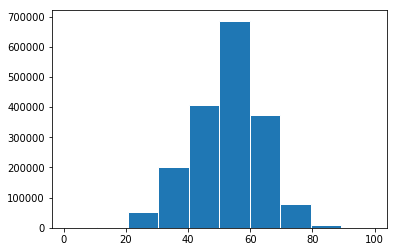

In [ ]:
plt.hist(USERS.AGE.dropna().to_list(),edgecolor='w')

In [ ]:
USERS.rename(columns={'CUST_NO':'USER_ID'},inplace=True)

In [ ]:
#USERS.SEX.astype('category')

In [ ]:
USERS.AGE.fillna(USERS.AGE.mean(), inplace=True)

In [ ]:
USERS.rename(columns={'CUST_GB_NM':'CUST_GB_NAME'}, inplace=True)

In [ ]:
USERS.loc[:,'AGE']=USERS.AGE.astype('int64')

In [ ]:
USERS.to_csv('user_age_sex_freq.csv')

In [ ]:
schema = {
  "type": "record",
  "name": "Users",
  "namespace": "com.amazonaws.personalize.schema",
  "fields": [
      {
          "name": "USER_ID",
          "type": "string"
      },
      {
          "name": "AGE",
          "type": "int"
      },
      {
          "name": "SEX",
          "type": "string",
          "categorical": True
      },
      {
          "name": "ADDR",
          "type": "string",
          "categorical": True
      },
      {
          "name": "CUST_GB_NAME",
          "type": "string",
          "categorical": True
      },
      {
          "name": "freq",
          "type": "int"
      }
  ],
  "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "users_age_sex_freq",
    schema = json.dumps(schema)
)

schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-west-2:351072964306:schema/users_age_sex_freq",
  "ResponseMetadata": {
    "RequestId": "d42da348-efb2-42b1-821c-c428742fd90f",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Wed, 26 Jun 2019 05:02:49 GMT",
      "x-amzn-requestid": "d42da348-efb2-42b1-821c-c428742fd90f",
      "content-length": "84",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
create_dataset_group_response = personalize.create_dataset_group(
    name = "hrnn_meta_third_event_type"
)

dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

{
  "datasetGroupArn": "arn:aws:personalize:us-west-2:351072964306:dataset-group/hrnn_meta_third_event_type",
  "ResponseMetadata": {
    "RequestId": "f3eef485-5867-4e67-868a-712335fefed2",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 28 Jun 2019 08:58:58 GMT",
      "x-amzn-requestid": "f3eef485-5867-4e67-868a-712335fefed2",
      "content-length": "105",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


In [ ]:
dataset_type = "USERS"
create_dataset_response = personalize.create_dataset(
    name = "users_age_sex_freq",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = "arn:aws:personalize:us-west-2:351072964306:schema/users_age_sex_freq"
)

dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-west-2:351072964306:dataset/hrnn_meta_third_event_type/USERS",
  "ResponseMetadata": {
    "RequestId": "bd358096-8fbf-41af-b515-4ac0ccfd4132",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 28 Jun 2019 08:59:22 GMT",
      "x-amzn-requestid": "bd358096-8fbf-41af-b515-4ac0ccfd4132",
      "content-length": "100",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
role_arn = "arn:aws:iam::351072964306:role/PersonalizeS3Role"

In [ ]:
bucket = 'personalize-dsc'

In [ ]:
filename = 'user_age_sex_freq.csv'

In [ ]:
USERS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2170315 entries, 0 to 3448759
Data columns (total 6 columns):
USER_ID         int64
AGE             int64
SEX             object
ADDR            object
CUST_GB_NAME    object
freq            int64
dtypes: int64(3), object(3)
memory usage: 115.9+ MB


In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object(filename).upload_file(filename)

In [ ]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "user-import-job-5",
    datasetArn = "arn:aws:personalize:us-west-2:351072964306:dataset/hrnn_meta_third_event_type/USERS",
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, 'user_age_sex_freq.csv')
    },
    roleArn = role_arn
)

dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-west-2:351072964306:dataset-import-job/user-import-job-5",
  "ResponseMetadata": {
    "RequestId": "ee155276-04f8-48b6-9319-ef38711aef09",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 28 Jun 2019 09:55:48 GMT",
      "x-amzn-requestid": "ee155276-04f8-48b6-9319-ef38711aef09",
      "content-length": "105",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### INTERACTIONS

1. no cart data

In [ ]:
schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "interactions",
    schema = json.dumps(schema)
)

schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-west-2:351072964306:schema/interactions",
  "ResponseMetadata": {
    "RequestId": "b49bc9e2-19c1-4388-b7f5-dd40eca039d7",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Wed, 26 Jun 2019 05:24:20 GMT",
      "x-amzn-requestid": "b49bc9e2-19c1-4388-b7f5-dd40eca039d7",
      "content-length": "78",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


2. Cart Data

In [ ]:
schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        },
        {
            "name": "EVENT_TYPE",
            "type": "string",
            "categorical": True
        },
        {
            "name": "HOLLIDAY",
            "type": "string",
            "categorical": True
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "interactions-event-holliday",
    schema = json.dumps(schema)
)

schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-west-2:351072964306:schema/interactions-event-holliday",
  "ResponseMetadata": {
    "RequestId": "4380c6d3-9989-4fcc-ab21-8f2701f902f2",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 28 Jun 2019 09:00:47 GMT",
      "x-amzn-requestid": "4380c6d3-9989-4fcc-ab21-8f2701f902f2",
      "content-length": "93",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
df[['GOODS_CODE','CUST_NO','ORDER_DATE']].head()

,GOODS_CODE,CUST_NO,ORDER_DATE
0,10060956,201611266992,2019/01/14 11:47
1,10056895,201608923519,2019/01/21 20:07
2,10062781,201601299917,2019/01/18 17:23
3,10050745,201605742571,2019/01/16 23:23
4,10050867,201601282310,2019/01/28 22:25


In [ ]:
z = zzim[['USER_ID','ITEM_ID','TIMESTAMP','EVENT_TYPE']][zzim.USER_ID.isin(USERS.USER_ID)]

In [ ]:
df.reset_index(inplace=True)
df.loc[:, 'ORDER_DATE'] = pd.to_datetime(df['ORDER_DATE'], format='%Y-%m-%d')


In [ ]:
df.reset_index(inplace=True)

In [ ]:
inter = df[['CUST_NO','GOODS_CODE','ORDER_DATE']].copy()

In [ ]:
inter.rename(columns = {'CUST_NO':'USER_ID','GOODS_CODE':'ITEM_ID','ORDER_DATE':'TIMESTAMP'},inplace=True)

In [ ]:
inter['EVENT_TYPE'] = 'sale'

In [ ]:
interaction = pd.concat([inter,z], axis=0)

In [ ]:
interaction.head(10)

,USER_ID,ITEM_ID,TIMESTAMP,EVENT_TYPE
0,201611266992,10060956,2019-01-14 11:47:00,sale
1,201608923519,10056895,2019-01-21 20:07:00,sale
2,201601299917,10062781,2019-01-18 17:23:00,sale
3,201605742571,10050745,2019-01-16 23:23:00,sale
4,201601282310,10050867,2019-01-28 22:25:00,sale


In [ ]:
interaction.loc[:,'TIMESTAMP'] = pd.to_datetime(interaction.TIMESTAMP, format='%Y-%m-%d')

In [ ]:
interaction.set_index('TIMESTAMP', inplace=True)
interaction['HOLLIDAY'] = 0
interaction.loc[interaction['2019-02-02':'2019-02-06'].index, 'HOLLIDAY'] = 1
interaction.loc[interaction['2019-01-01'].index, 'HOLLIDAY'] = 2
interaction.loc[interaction['2019-03-01':'2019-03-03'].index, 'HOLLIDAY'] = 2
interaction.loc[interaction['2019-05-04':'2019-05-06'].index, 'HOLLIDAY'] = 2

In [ ]:
interaction.head()

,TIMESTAMP,USER_ID,ITEM_ID,EVENT_TYPE,HOLLIDAY
0,2019-01-14 11:47:00,201611266992,10060956,sale,0
1,2019-01-21 20:07:00,201608923519,10056895,sale,0
2,2019-01-18 17:23:00,201601299917,10062781,sale,0
3,2019-01-16 23:23:00,201605742571,10050745,sale,0
4,2019-01-28 22:25:00,201601282310,10050867,sale,0


In [ ]:
interaction.loc[:,'TIMESTAMP'] = interaction.TIMESTAMP.astype('int64')

In [ ]:
interaction.to_csv('interactions_holid.csv')

In [ ]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name = "zzim_and_sale_holiday",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = "arn:aws:personalize:us-west-2:351072964306:schema/interactions-event-holliday"
)

dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-west-2:351072964306:dataset/hrnn_meta_third_event_type/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "a864ebaa-b8aa-4611-bdec-75a446a3136c",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 28 Jun 2019 09:47:56 GMT",
      "x-amzn-requestid": "a864ebaa-b8aa-4611-bdec-75a446a3136c",
      "content-length": "107",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
filename = 'interactions_holid.csv'

In [ ]:
interaction.HOLLIDAY.unique()

array([0, 2, 1], dtype=int64)

In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object(filename).upload_file(filename)

In [ ]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "interaction-import-job3",
    datasetArn = "arn:aws:personalize:us-west-2:351072964306:dataset/hrnn_meta_third_event_type/INTERACTIONS",
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, 'interactions_holid.csv')
    },
    roleArn = role_arn
)

dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-west-2:351072964306:dataset-import-job/interaction-import-job3",
  "ResponseMetadata": {
    "RequestId": "5d98ea0e-7db6-40a5-963f-37a3a0160b22",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 28 Jun 2019 09:56:42 GMT",
      "x-amzn-requestid": "5d98ea0e-7db6-40a5-963f-37a3a0160b22",
      "content-length": "111",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### ITEM meta data

In [ ]:
items = df[['GOODS_CODE','GOODS_NAME', 'LGROUP_NAME', 'MGROUP_NAME',
       'SGROUP_NAME', 'DGROUP_NAME', 'MD_CODE', 'BRAND_CODE',
       'ITEM_CODE', 'SALE_PRICE', 'SALE_GB','SH_MAN_ID',
       'SH_SUB_ID']].rename(columns={'GOODS_CODE':'ITEM_ID'})

In [ ]:
items.loc[:,'SH_MAN_ID'] = items.SH_MAN_ID.fillna('SSG')
items.loc[:,'SH_SUB_ID'] = items.SH_SUB_ID.fillna('SSG')

In [ ]:
items['TITLE_PROMO'] = items.GOODS_NAME.str.contains(title)

In [ ]:
values = {'TITLE_PROMO': 2,}
items = items.fillna(value=values)
items['TITLE_PROMO'] = items['TITLE_PROMO'].astype(int)

In [ ]:
items.head()

,ITEM_ID,GOODS_NAME,LGROUP_NAME,MGROUP_NAME,SGROUP_NAME,DGROUP_NAME,MD_CODE,BRAND_CODE,ITEM_CODE,SALE_PRICE,SALE_GB,SH_MAN_ID,SH_SUB_ID,TITLE_PROMO
0,10060956,[반값딜] 카밀 핸드크림 클래식 1+1,뷰티,이미용품,바디용품,핸드크림,61,2208,100632,8500,진행,SSG,SSG,0
1,10056895,(홀리데이 구성) 엘렌실라 달팽이크림 50g*5개 + EGF크림 50g*5개 + 파...,뷰티,화장품,기초화장품,기초세트,32,932,679,79000,판매중단,SSGSH002,SSGSH013,0
2,10062781,김나운 손질새우 140g(20미)/팩 x 13팩 (총 260미),식품,수산물,갑각류/패류,대하(새우),41,1826,100284,60900,판매중단,SSGSH017,SSGSH005,0
3,10050745,백년의삶 동안석류즙 70ml*105포 (N035),식품,가공식품,과즙음료,기타,41,2374,100884,79900,진행,SSGSH006,SSGSH013,0
4,10050867,(고객감사특가) 럭키샵 마르조 리버시블 항공점퍼 1+1,패션,여성의류,아우터,재킷,11,697,8126,39800,판매중단,SSGSH010,SSGSH008,1


In [ ]:
items.to_csv('items_all_serena.csv')

In [ ]:
items[['ITEM_ID', 'LGROUP_NAME', 'MGROUP_NAME', 'SGROUP_NAME','BRAND_CODE','TITLE_PROMO']].to_csv('item_second.csv')

In [ ]:
items[['ITEM_ID', 'LGROUP_NAME', 'MGROUP_NAME', 'SGROUP_NAME','BRAND_CODE','TITLE_PROMO']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3448760 entries, 0 to 697427
Data columns (total 6 columns):
ITEM_ID        int64
LGROUP_NAME    object
MGROUP_NAME    object
SGROUP_NAME    object
BRAND_CODE     int64
TITLE_PROMO    int32
dtypes: int32(1), int64(2), object(3)
memory usage: 171.0+ MB


In [ ]:
schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "LGROUP_NAME",
            "type": "string",
            "categorical": True
        },
        {
            "name": "MGROUP_NAME",
            "type": "string",
            "categorical": True
        },
        {
            "name": "SGROUP_NAME",
            "type": "string",
            "categorical": True
        },
        {
            "name": "BRAND_CODE",
            "type": "string",
            "categorical": True
        },
        {
            "name": "TITLE_PROMO",
            "type": "string",
            "categorical": True
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "items-second",
    schema = json.dumps(schema)
)

schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-west-2:351072964306:schema/items-second",
  "ResponseMetadata": {
    "RequestId": "dc4791db-edc6-49dd-a004-b92fa6678e03",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 28 Jun 2019 09:58:36 GMT",
      "x-amzn-requestid": "dc4791db-edc6-49dd-a004-b92fa6678e03",
      "content-length": "78",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
dataset_type = "ITEMS"
create_dataset_response = personalize.create_dataset(
    name = "item_all_title_promo",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = "arn:aws:personalize:us-west-2:351072964306:schema/items-second"
)

dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-west-2:351072964306:dataset/hrnn_meta_third_event_type/ITEMS",
  "ResponseMetadata": {
    "RequestId": "9b5abe93-6fb6-4d3a-b62b-68d132e800ce",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 28 Jun 2019 09:58:48 GMT",
      "x-amzn-requestid": "9b5abe93-6fb6-4d3a-b62b-68d132e800ce",
      "content-length": "100",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
filename = 'item_second.csv'

In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object(filename).upload_file(filename)

In [ ]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "item-import-job-4",
    datasetArn = "arn:aws:personalize:us-west-2:351072964306:dataset/hrnn_meta_third_event_type/ITEMS",
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, 'item_second.csv')
    },
    roleArn = role_arn
)

dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-west-2:351072964306:dataset-import-job/item-import-job-4",
  "ResponseMetadata": {
    "RequestId": "44fd2760-efd3-45ba-b95a-f7b5ec2d8901",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 29 Jun 2019 08:52:05 GMT",
      "x-amzn-requestid": "44fd2760-efd3-45ba-b95a-f7b5ec2d8901",
      "content-length": "105",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### describe dataset_import_job response

In [ ]:
status = None
max_time = time.time() + 3*60*60
while time.time() < max_time:
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
    datasetImportJobArn = "arn:aws:personalize:us-west-2:351072964306:dataset-import-job/item-import-job-4"

#        dataset_import_job_arn
    )
    status = describe_dataset_import_job_response["datasetImportJob"]['status']
    print("DatasetImportJob: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

DatasetImportJob: ACTIVE


In [ ]:
describe_dataset_import_job_response = personalize.describe_dataset_import_job(
    datasetImportJobArn = "arn:aws:personalize:us-west-2:351072964306:dataset-import-job/item-import-job-2"
)
status = describe_dataset_import_job_response["datasetImportJob"]['status']
print("DatasetImportJob: {}".format(status))

DatasetImportJob: CREATE IN_PROGRESS


### Create Solution

In [ ]:
list_recipes_response = personalize.list_recipes()

In [ ]:
list_recipes_response

{'recipes': [{'name': 'aws-hrnn',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 9, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2019, 6, 20, 9, 53, 10, 241000, tzinfo=tzlocal())},
  {'name': 'aws-hrnn-coldstart',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn-coldstart',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 9, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2019, 6, 20, 9, 53, 10, 241000, tzinfo=tzlocal())},
  {'name': 'aws-hrnn-metadata',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn-metadata',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 9, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2019, 6, 20, 9, 53, 10, 241000, tzinfo=tzlocal())},
  {'name': 'aws-personalized-ranking',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-personalized-ranking',
   's

In [ ]:
recipe_arn = "arn:aws:personalize:::recipe/aws-popularity-count"

In [ ]:
create_solution_response = personalize.create_solution(
    name= "aws-popularity-count-2",
    datasetGroupArn = dataset_group_arn,
    performAutoML = True
)
solution_arn = create_solution_response['solutionArn']
print(json.dumps(create_solution_response, indent=2))

{
  "solutionArn": "arn:aws:personalize:us-west-2:351072964306:solution/aws-popularity-count-2",
  "ResponseMetadata": {
    "RequestId": "fe855fa5-e389-469c-ab26-9ce6e27ac4de",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sun, 30 Jun 2019 02:20:46 GMT",
      "x-amzn-requestid": "fe855fa5-e389-469c-ab26-9ce6e27ac4de",
      "content-length": "92",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
create_solution_version_response = personalize.create_solution_version(
    solutionArn = solution_arn)

solution_version_arn = create_solution_version_response['solutionVersionArn']
print(json.dumps(create_solution_version_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:us-west-2:351072964306:solution/aws-popularity-count-2/d550845c",
  "ResponseMetadata": {
    "RequestId": "dd2a33bb-83fe-41c3-bbcd-611dc8365702",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sun, 30 Jun 2019 02:20:52 GMT",
      "x-amzn-requestid": "dd2a33bb-83fe-41c3-bbcd-611dc8365702",
      "content-length": "108",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
status = None
max_time = time.time() + 3*60*60
while time.time() < max_time:
    describe_solution_version_response = personalize.describe_solution_version(
        solutionVersionArn = solution_version_arn
    )
    status = describe_solution_version_response["solutionVersion"]["status"]
    print("SolutionVersion: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_P

In [ ]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:us-west-2:351072964306:solution/aws-popularity-count-2/d550845c",
  "metrics": {
    "coverage": 0.0541,
    "mean_reciprocal_rank_at_25": 0.1527,
    "normalized_discounted_cumulative_gain_at_10": 0.1909,
    "normalized_discounted_cumulative_gain_at_25": 0.2132,
    "normalized_discounted_cumulative_gain_at_5": 0.1767,
    "precision_at_10": 0.024,
    "precision_at_25": 0.0132,
    "precision_at_5": 0.0396
  },
  "ResponseMetadata": {
    "RequestId": "2d8eae8e-f010-4064-8372-4edae3a2d269",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sun, 30 Jun 2019 10:26:11 GMT",
      "x-amzn-requestid": "2d8eae8e-f010-4064-8372-4edae3a2d269",
      "content-length": "405",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
create_campaign_response = personalize.create_campaign(
    name = "shinsege-campaign-popular",
    solutionVersionArn = solution_version_arn,
    minProvisionedTPS = 100
)

campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))

{
  "campaignArn": "arn:aws:personalize:us-west-2:351072964306:campaign/shinsege-campaign-popular",
  "ResponseMetadata": {
    "RequestId": "31f80983-d571-4473-a70f-74bb45033a16",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sun, 30 Jun 2019 12:01:07 GMT",
      "x-amzn-requestid": "31f80983-d571-4473-a70f-74bb45033a16",
      "content-length": "95",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
def get_recommendation(user_id, campaign_arn):
    get_recommendation_response = personalize_runtime.get_recommendations(
    campaignArn = campaign_arn,
    userId = str(user_id),
    #numResult = 
    #itemId = str(item_id)
    )
    item_list = get_recommendation_response['itemList']
    title_list = [items.loc[items['ITEM_ID'] == np.int(item['itemId'])].values[0][1] for item in item_list]
    
    return title_list

In [ ]:
for user_id in USERS.USER_ID.values[:10]:
    get_recommendation(user_id)

In [ ]:
full_get_rec_pop = {i:get_recommendation(i,"arn:aws:personalize:us-west-2:351072964306:campaign/shinsege-campaign-popular" ) for i in USERS.USER_ID.values}

In [ ]:
full_get_rec_hrnn = 

In [ ]:
pd.set_option('max_columns', 100)
pd.DataFrame(full_get_rec)

,201411002482,201411002483,201412000902,201412000915,201412000936,201412001016,201412001083,201501002501,201501002523,201501002525,201501002526,201501002527,201501002528,201501002531,201501002539,201501002544,201501002546,201501002560,201501002562,201501002565,201501002570,201501002576,201501002582,201501002587,201501002592,201501002593,201501002599,201501002601,201501002607,201501002615,201501002631,201501002636,201501002656,201501002676,201501002684,201501002693,201501002721,201501002722,201501002723,201501002731,201501002734,201501002741,201501002755,201501002759,201501002763,201501002769,201501002771,201501002787,201501002788,201501002805,201501002808,201501002809,201501002810,201501002811,201501002815,201501002839,201501002842,201501002860,201501002866,201501002867,201501002869,201501002874,201501002875,201501002877,201501002906,201501002908,201501002911,201501002936,201501002937,201501002962,201501002987,201501002994,201501003002,201501003005,201501003007,201501003008,201501003016,201501003017,201501003033,201501003038,201501003044,201501003050,201501003060,201501003063,201501003073,201501003086,201501003088,201501003122,201501003123,201501003149,201501003151,201501003153,201501003156,201501003163,201501003171,201501003172,201501003173,201501003180,201501003183,201501003188
0,조성아TM 슈퍼 핏 커버 스틱파운데이션 2개,(M-2차예판)소니캐스트 디렘(direm) HT1 (예약판매/6월17일부터 순차 발...,조성아TM 슈퍼 핏 커버 스틱파운데이션 2개,[맥퀸뉴욕] 워터프루프 젤 아이라이너 1+1,(행사)CJ 고메 함박스테이크 152g*10팩,조성아TM 슈퍼 핏 커버 스틱파운데이션 2개,"(공기청정, 에너지효율 1등급) 캐리어 고급형 에어컨 멀티 AMC16VX2MFNGH",[단독특가] 모나코비 썸머 코튼 셔츠3종,(ALL NEW!! 5리터)일렉트로맨 프리미엄 디지털 에어프라이어(AFG-18011D),[신세계단독](여성)19SS 휠라 플렉스무브 트랙수트 3종(직),(3월 한정) CK 코튼 스트레치 드로즈 패키지 6종,(50프로SALE) Aneta by신영와코루 컴포트 브라팬티 (사은품1세트 더),헤드스파7 김희애 헤어트리트먼트 200ml x4,(프리미엄)이즈미 보풀제거기 IKL-600,(여성)르까프 경량 구스다운 2종 세트,NEW 나인테일즈 링클파워 세럼 세트,오델로 여름 모자 4종 (summer special package),(S) Rouzili 로질리 볼륨 블라우스 4종,에스디펠레 소가죽 로퍼+슬립온+스니커즈 패키지(남),NEW 나인테일즈 링클파워 세럼 세트,씻어나온 보조개 사과 3kg*3박스,NEW 나인테일즈 링클파워 세럼 세트,맥슨(maxon) 블루투스 라디오 스피커 붐박스 (MXBT 3000) + 오리지널 ...,롤리오 헤어쿠션 시즌한정 패키지 (s),"썬키스트 블랙라벨 고당도 오렌지 9kg, 60과 (20과*3박스)",(방송최저가) 럭키샵 마르조 웜데이 퀼팅 롱 패딩 + 베스트 세트,연세 뼈를생각한 고칼슘 검은콩두유190ml x 48팩+고칼슘 호두아몬드두유 190m...,(방송에서만)요리연구가 이보은의 고기국물 진한 특 소 한 마리탕 750g x 8팩 ...,스튜디오럭스(Studio Lux) 밴딩 슬렉스 4종,"[M2] 스탠드형 선풍기 M2-3562 (5엽/35CM/블랙,화이트 택1)",(S) Rouzili 로질리 코튼100 모던 원피스 3종,96NY(나인식스뉴욕) 플렉서블 감탄 팬츠 4종,[극한혜택 10만원 할인] 로베라 초슬림 파워워킹패드 + 전 고객 사은품 증정 (...,연세 뼈를생각한 고칼슘 검은콩두유190ml x 48팩+고칼슘 호두아몬드두유 190m...,2018FW 푸마 웜셀 긴팔형 기모브라탑 4종,크리스티나앤코 쿨 니트 블라우스 4종+나시티셔츠 세트,NEW 나인테일즈 링클파워 세럼 세트,씻어나온 보조개 사과 3kg*3박스,씻어나온 보조개 사과 총 3박스,NEW 나인테일즈 링클파워 세럼 세트,NEW 나인테일즈 링클파워 세럼 세트,양희경 반기수라 손질 낙지 135g/팩 x 15팩 + 비법양념 50g/봉 x 15봉,[김혜수의선택] 마르엘라 로사티 롱 가디건+티블라우스 세트,(기획특가) Aneta by신영와코루 릴랙스 브라팬티,Aneta by신영와코루 파워보정 프리컷 브라,NEW 나인테일즈 링클파워 세럼 세트,(1+1) 코미트(COMIT) 무선 충전 거치대 (사은품 퀄컴 3.0 듀얼포트 시거잭),(1만원 인하)루케테 하이부스트슈즈+워킹화+슬립온 패키지(여),(여성)애플라인드 트리코트 아이스큐브 셔츠 3종,오지호의 V.CUT(브이컷) 남성 이지케어 린넨셔츠 3종,연세 뼈를생각한 고칼슘 검은콩두유190ml x 48팩+고칼슘 호두아몬드두유 190m...,(1만원 인하)루케테 하이부스트슈즈+워킹화+슬립온 패키지(여),오지호의 V.CUT(브이컷) 남성 이지케어 린넨셔츠 3종,델첸 텀블러 멀티 블렌더(사은품:쿨러백),(방송최저가) s.a.d.e 샤데이 2019 퍼팩트핏 슬랙스 3종,NEW 나인테일즈 링클파워 세럼 세트,워모 (LUOMO) 썸머 코튼 폴로셔츠 3종,(1만원 인하)루케테 하이부스트슈즈+워킹화+슬립온 패키지(남),[초특가] 마르엘라 로사티 실켓 코튼100 컬러팝 티셔츠 4종,"롯데렌터카 4월 전기차 특별전 (폐기, 3월분 오기)",NEW 나인테일즈 링클파워 세럼 세트,오지호의 V.CUT(브이컷) 남성 이지케어 린넨셔츠 3종,NEW 나인테일즈 링클파워 세럼 세트,"썬키스트 블랙라벨 고당도 오렌지 9kg, 60과 (20과*3박스)",NEW 나인테일즈 링클파워 세럼 세트,(방송최저가) 럭키샵 마르조 웜데이 퀼팅 롱 패딩 + 베스트 세트,차아네 6단 트랜스포머 차량용 컵홀더 1+1세트(멀티수납함증정),(행사)신세계푸드 올반 찰핫도그80g*20봉,[가격인하!] Rouzili 로질리 패커블 윈드 트렌치 1+1,2018FW 푸마 웜셀 긴팔형 기모브라탑 4종,NEW 나인테일즈 링클파워 세럼 세트,"(단독특가, 방송에서만 이가격!) 시메오 프리미엄 디지털 에어프라이어 [DK-20-1]",NEW 나인테일즈 링클파워 세럼 세트,[신세계단독] 모나코비(MONACO.B) 린넨100 재킷,*(최신상) 아디다스(adidas) 테크바디 런닝 총6종,차아네 6단 트랜스포머 차량용 컵홀더 1+1세트(멀티수납함증정),Cout-J. 꾸뜨제이 19SS 탄성 슬랙스 4종,NEW 나인테일즈 링클파워 세럼 세트,NEW 나인테일즈 링클파워 세럼 세트,NEW 나인테일즈 링클파워 세럼 세트,[초특가](여성)험멜 쉐브론 트랙수트 3종,(적립금 10프로+정품 음파칫솔 증정)NEW 파나소닉 제트워셔 구강세정기 풀세트,마리타후리나이넨 편안한 3step 넬이오 양가죽 펌프스,NEW 나인테일즈 링클파워 세럼 세트,NEW 나인테일즈 링클파워 세럼 세트,[원데이특가] 로사W 와이드 팬츠2종,[50프로 세일] 렉스파 알파 스쿼트 머신,NEW 나인테일즈 링클파워

In [ ]:
pd.DataFrame(full_get_rec).to_csv('sample_rec_poplur.csv',encoding='korean')

In [ ]:
user_id = np.random.choice(df.CUST_NO)
get_recommendation_response = personalize_runtime.get_recommendations(
    campaignArn = campaign_arn,
    userId = str(user_id),
    #numResult = 
    #itemId = str(item_id)
)

item_list = get_recommendation_response['itemList']
title_list = [items.loc[items['ITEM_ID'] == np.int(item['itemId'])].values[0][1] for item in item_list]
title_list

['(극한혜택) 엘로엘 팡팡 빅 선쿠션 UD 세트 ',
 '(극한혜택 더블구성) 엘로엘 팡팡 빅 선쿠션 UD 세트 ',
 '(New) 엘로엘 팡팡 빅 선쿠션 UD 세트 ',
 '(극한혜택) 엘로엘 팡팡 빅 선쿠션 UD 세트 ',
 '조성아 원더바스 베지톡스 클렌저 세트 ',
 '(최다구성) 엘로엘 팡팡 빅 선쿠션 UD 세트 ',
 '아미니 풋스파 풀패키지',
 '[50프로 세일] 렉스파 알파 스쿼트 머신',
 '일동제약 프로바이오틱 마스크팩 77매(s)',
 '제스프리 썬골드키위 특대사이즈 3.5kg (과당 130g-140g 내외, 24-27과, 키위스푼 10개 증정)',
 '헤드스파7 김희애 헤어트리트먼트 200ml x4',
 'NEW 나인테일즈 링클파워 세럼 세트',
 '게리쏭 마유쿠션 기획세트',
 '(싸군딜)신선한 2019년 햇감자 3kg(중)',
 '올리브그린 코튼슬럽 레터링 티셔츠 5종',
 '(여성) 닉스(NIX) 썸머 아이스데님 + 언더웨어 5종',
 '땡큐 프리미엄 30롤 3팩',
 '롤리오 헤어쿠션 시즌한정 패키지 (s)',
 '(사은품 써큘레이터 2대) LG 휘센 에어컨 2-in-1 FQ17V9KWA2 (56.9(17)+22.8(7)/스마트케어/제습/Wi-Fi)',
 '스튜디오럭스(Studio Lux) 밴딩 슬렉스 4종',
 '(최다구성) 엘로엘 팡팡 빅 선쿠션 UD 세트 ',
 '하비비 청개구리 멀티클리너 세트(변기/싱크대/세탁조/배수구)',
 'Aneta by신영와코루 파워보정 프리컷 브라',
 '(강성연의 온가족 선쿠션) 스포메틱스 그린 네츄럴 선쿠션 세트',
 '[미세플라스틱Free] 아우라 초고농축 섬유유연제 프레쉬 딜라이트 2종 1L x2개']

 재구매 고객

In [ ]:
cust_ret = df[df.LAST_ORDER_DATE != df.ORDER_DATE]

기존 고객

In [ ]:
cust_ret.head()

,ORDER_NO,GOODS_CODE,GOODS_NAME,LGROUP_NAME,MGROUP_NAME,SGROUP_NAME,DGROUP_NAME,SALE_PRICE,SALE_GB,ORDER_DATE,...,BIRTHDAY,SEX,ADDR,CUST_GB_NM,WITHDRAWAL_YN,CUST_INSERT_DATE,INSERT_MEDIA,MEMB_GB,FIRST_ORDER_DATE,LAST_ORDER_DATE
0,20190114221750,10060956,[반값딜] 카밀 핸드크림 클래식 1+1,뷰티,이미용품,바디용품,핸드크림,8500,진행,2019-01-14,...,198006.0,여,강원도/동해시,회원,0,2016.11.19,모바일,일반,2016.11.19 13:56,2019.1.14
1,20190121274335,10056895,(홀리데이 구성) 엘렌실라 달팽이크림 50g*5개 + EGF크림 50g*5개 + 파...,뷰티,화장품,기초화장품,기초세트,79000,판매중단,2019-01-21,...,197004.0,여,강원도/동해시,회원,0,2016.8.30,ARS자동,일반,2016.8.30 20:09,2019.1.21
2,20190123337551,10065231,[초특가](여성)험멜 패딩자켓+덕다운베스트 2종 세트,패션,스포츠레저캠핑,스포츠의류,다운/패딩,49000,판매중단,2019-01-23,...,196208.0,여,강원도/동해시,회원,0,2016.5.20,상담사,일반,2016.5.20 17:27,2019.2.15
3,20190131416677,10065090,(설) 나주고깃간 LA갈비 500g*9팩 (총4.5KG) (N033),식품,가공식품,축산가공식품,세트,89900,진행,2019-01-31,...,196611.0,여,강원도/동해시,회원,0,2015.8.12,상담사,일반,2015.8.12 13:39,2019.1.31
4,20190131407599,10060442,2018FW 푸마 웜셀 긴팔형 기모브라탑 4종,패션잡화,언더웨어,여성속옷,내의,69000,판매중단,2019-01-31,...,196611.0,여,강원도/동해시,회원,0,2015.8.12,상담사,일반,2015.8.12 13:39,2019.1.31


In [ ]:
cust_old = df1[df1.LAST_ORDER_DATE != df1.FIRST_ORDER_DATE]

In [ ]:
print(len(cust_ret.CUST_NO.unique()))

NameError: name 'cust_ret' is not defined

In [ ]:
print(len(cust_old.CUST_NO.unique()))

1154466


In [ ]:
(cust_ret.LAST_ORDER_DATE - cust_ret.ORDER_DATE).astype('timedelta64[D]').sum()/cust_ret.shape[0]

49.25108501865604

In [ ]:
(df_re.LAST_ORDER_DATE - df_re.FIRST_ORDER_DATE).astype('timedelta64[D]').sum()/2280863

574.5952843287826

(0, 141.75)

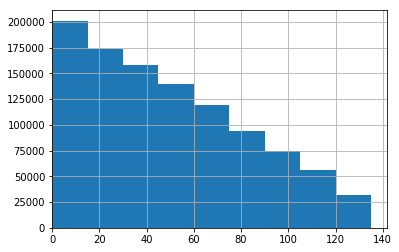

In [ ]:
(cust_ret.LAST_ORDER_DATE - cust_ret.ORDER_DATE).astype('timedelta64[D]').hist(bins=np.arange(0,150,15))
plt.xlim(0,)

In [ ]:
cust_ret_clean = cust_ret[(cust_ret.LAST_ORDER_DATE - cust_ret.ORDER_DATE).astype('timedelta64[D]') > 0]

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
(cust_ret_clean.LAST_ORDER_DATE - cust_ret_clean.ORDER_DATE).astype('timedelta64[D]').value_counts().to_csv('return_cust.csv')

/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
(cust_ret_clean.LAST_ORDER_DATE - cust_ret_clean.ORDER_DATE).astype('timedelta64[D]').value_counts(bins=np.arange(0,150,15))

(-0.001, 15.0]    213431
(15.0, 30.0]      171852
(30.0, 45.0]      157144
(45.0, 60.0]      138576
(60.0, 75.0]      118003
(75.0, 90.0]       93044
(90.0, 105.0]      73499
(105.0, 120.0]     54327
(120.0, 135.0]     29195
dtype: int64

In [ ]:
cust_ret_clean['GOODS_NAME'].value_counts()

NameError: name 'cust_ret_clean' is not defined

In [ ]:
df['GOODS_NAME'].value_counts()[:20].to_csv('value_count_top20.csv', encoding='korean')

/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
top_20_items = df['GOODS_NAME'].value_counts().index[:20]

In [ ]:
top_20_df = df.set_index('GOODS_NAME').loc[top_20_items]

In [ ]:
top_20_df = top_20_df.reset_index().drop_duplicates(subset='GOODS_NAME')

In [ ]:
top_20_df.iloc[:, [0,3,4,5,6,8]].to_csv('top_20_df.csv', encoding='korean')

In [ ]:
top_20_df.columns

Index(['GOODS_NAME', 'ORDER_NO', 'GOODS_CODE', 'LGROUP_NAME', 'MGROUP_NAME',
       'SGROUP_NAME', 'DGROUP_NAME', 'SALE_PRICE', 'SALE_GB', 'ORDER_DATE',
       '방송주문여부', 'ORDER_MEDIA', 'SETTLE_NAME', 'CARD_NAME', 'DC_ARS',
       'DC_NOREST', 'DC_GOODS', 'DC_COUPON', 'DC_AMT_PARTNER', 'RSALE_AMT',
       'CUST_NO', 'BIRTHDAY', 'SEX', 'ADDR', 'CUST_GB_NM', 'WITHDRAWAL_YN',
       'CUST_INSERT_DATE', 'INSERT_MEDIA', 'MEMB_GB', 'FIRST_ORDER_DATE',
       'LAST_ORDER_DATE'],
      dtype='object')

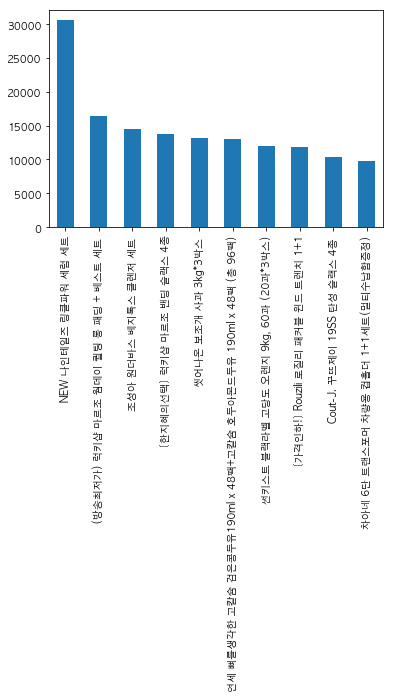

In [ ]:
cust_ret_clean['GOODS_NAME'].value_counts()[:10].plot(kind='bar')